# Chord analysis
In this notebook, we perform analysis of the chord-related features in the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import ast

In [572]:
songs = pd.read_json('data/songs_with_sentiment.json.bz2', compression='bz2')
songs['chords'] = songs['chords'].apply(lambda chords: ast.literal_eval(chords))
songs['nr_chords'] = songs['chords'].apply(lambda chords: len(chords))
songs.head(2)

,name,author,link,lyrics,chords,genre,actual_name,language,clean_lyrics,emotion,sentiment,sentiment_name,nr_chords,sentiment_compound
0,As Long As The Grass Shall Grow,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"As long, As the moon shall rise, As ...","[A, E, A, A, E, A, D, D, A, D, D, A, A, D, E, ...",Country,As Long As The Grass Shall Grow,en,"As long, As the moon shall rise, As ...","[joy, neutral, anger]","{'neg': 0.07200000000000001, 'neu': 0.844, 'po...",positive,124,0.7003
1,Delias Gone (ver 4),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Delia, oh, Delia Delia all my life\r\nIf I had...","[A, D, A, A7, D, B7, E, A, D, A, E, A, A, D, A...",Country,Delias Gone,en,"Delia, oh, Delia Delia all my life If I hadn't...","[anger, fear, sad]","{'neg': 0.094, 'neu': 0.872, 'pos': 0.035, 'co...",negative,69,-0.8903


#### Sentiment of chord progressions
Here, we want to understand if the distribution of 4-grams is different for the lyrics with positive and negative sentiment. Intuitively, the songs with positive sentiment should have more major chords while the negative ones should have more minor chords.

In [579]:
def convert_string_to_ngrams_list (chords, ngram = 4):
    """
    converts the list of chords to list of ngrams, each ngram is one list
    """
    temp = zip(*[chords[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]

    return ans
songs['ngrams'] = songs['chords'].apply(lambda x: convert_string_to_ngrams_list(x,4))
songs['ngrams'] = songs['ngrams'].apply(lambda x:  x if len(x) > 0 else np.NaN)
songs = songs.dropna(subset=["ngrams"])
songs["best_ngram"] = songs['ngrams'].apply( lambda x:  tuple(list(Counter(x).most_common(1))[0][0].split()))


In [580]:
positive = songs[songs.sentiment_name == 'positive']
negative = songs[songs.sentiment_name == 'negative']

Plot distribution of best 4-grams for positive and negative songs

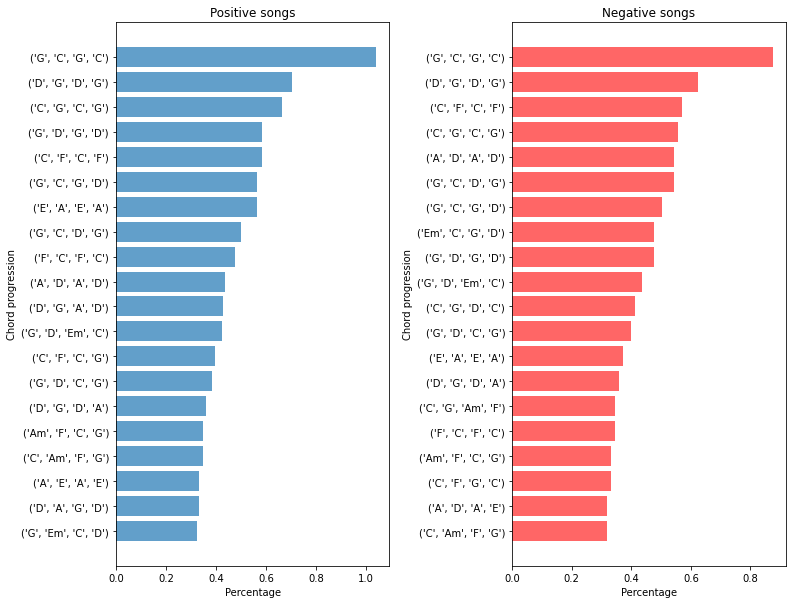

In [587]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

top = 20

ax[0].barh(range(top), 100 * positive['best_ngram'].value_counts().values[:top][::-1] / positive.shape[0], alpha=0.7)
_ = ax[0].set_yticks(range(top))
_ = ax[0].set_yticklabels(positive['best_ngram'].value_counts().keys()[:top][::-1])
_ = ax[0].set_title('Positive songs')
_ = ax[0].set_xlabel('Percentage')
_ = ax[0].set_ylabel('Chord progression')

nr_unique_ngrams_negative = len(negative.drop_duplicates(['best_ngram']))
ax[1].barh(range(top), 100 * negative['best_ngram'].value_counts().values[:top][::-1] / negative.shape[0], color='r', alpha=0.6)
_ = ax[1].set_yticks(range(top))
_ = ax[1].set_yticklabels(negative['best_ngram'].value_counts().keys()[:top][::-1])
_ = ax[1].set_title('Negative songs')
_ = ax[1].set_xlabel('Percentage')
_ = ax[1].set_ylabel('Chord progression')

plt.subplots_adjust(wspace=0.45)

### Q1: Are minor chords more present in chord progressions with negative sentiment?
To extract more easily readable information from the plot above, count the number of minor chords among the top 200 negative and positive songs. According to our intuition as musicians, sad songs have more minor chords than happy ones.

In [524]:
top = 200

# Top 10 n-grams with most positive sentiment
top_positive_ngrams = songs.groupby(by=['best_ngram'], as_index=False).mean().sort_values(by='sentiment_compound')[-top:]

# Top 10 n-grams with most negative sentiment
top_negative_ngrams = songs.groupby(by=['best_ngram'], as_index=False).mean().sort_values(by='sentiment_compound')[:top]

def count_minors(top_ngrams):
    minor_count = 0
    for ngram in top_ngrams: #top_negative_ngrams.best_ngram.values:
        for chord in ngram:
            if 'm' in chord and 'maj' not in chord:
                minor_count += 1
    return minor_count
print(f'Number of minor chords among NEGATIVE songs: {count_minors(top_negative_ngrams.best_ngram.values)}')
print(f'Number of minor chords among POSITIVE songs: {count_minors(top_positive_ngrams.best_ngram.values)}')

Number of minor chords among NEGATIVE songs: 279
Number of minor chords among POSITIVE songs: 289


**CONCLUSION**: It doesn't seem that we can draw the conclusion that sad songs have more minor chords than happy ones using this dataset.

### Q2: What are the length of the chord sequences in the dataset?
By "chord sequences" here we mean all the chords in the song.

Plot distribution of length of chord progressions

In [525]:
def get_nr_of_chords(song_name):
    return len(songs.loc[songs.actual_name == song_name].chords.values[0])

print('Reference values of number of chords:\n')
song_name = 'Bohemian Rhapsody'
print(f'Number of chords of {song_name}: {get_nr_of_chords(song_name)}')
song_name = 'Strawberry Fields Forever'
print(f'Number of chords of {song_name}: {get_nr_of_chords(song_name)}')

Reference values of number of chords:

Number of chords of Bohemian Rhapsody: 211
Number of chords of Strawberry Fields Forever: 80


In [526]:
print(f"Min number of chords: {songs['nr_chords'].min()}")
print(f"Max number of chords: {songs['nr_chords'].max()}")

Min number of chords: 4
Max number of chords: 1894


In [527]:
print(f" {100 * (songs['nr_chords'].values < 250).sum() / len(songs['nr_chords'].values):.2f}% of songs have less than 250 chords")

 99.54% of songs have less than 250 chords


**CONCLUSION**: See below. As printed right above, 99.54% of all songs have less than 250 chords.

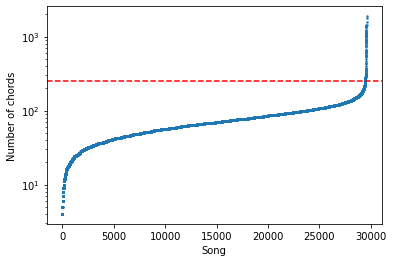

In [514]:
sorted_nr_chords = np.sort(songs['nr_chords'].values)
plt.scatter(range(len(sorted_nr_chords)), sorted_nr_chords, s=2)
plt.axhline(y=250, color='r', linestyle='--')
_ = plt.xlabel('Song')
_ = plt.ylabel('Number of chords')
_ = plt.yscale('log')

### Known bugs

**Bug 1**: See below an example that sometimes the chords weren't extracted perfectly: see the chords of the song ["Fight for love"](https://tabs.ultimate-guitar.com/tab/elliott-yamin/fight-for-love-chords-834215), it has clearly more than 4 chords, but due to the fact as the page is organized and we extracted the html elements, we get this error.

In [568]:
print(songs.loc[songs['nr_chords'] == 4][['name', 'author', 'chords', 'link']].shape)
songs.loc[songs['nr_chords'] == 4][['name', 'author', 'chords', 'link']].head(5)

(21, 4)


,name,author,chords,link
686,A Boy Named Sue,Shel Silverstein,"[A, D, A, D]",https://tabs.ultimate-guitar.com/tab/shel-silv...
3773,Cant Leave You Alone,Susan Tedeschi,"[B, A, E, F#m]",https://tabs.ultimate-guitar.com/tab/susan-ted...
4471,Angel Dance,Robert Plant,"[C, C, C, C]",https://tabs.ultimate-guitar.com/tab/robert-pl...
5565,Nada,The Refreshments,"[F, C, F, C]",https://tabs.ultimate-guitar.com/tab/the-refre...
5851,Those Final Feet,Cowboy Junkies,"[G, Am, C, G]",https://tabs.ultimate-guitar.com/tab/cowboy-ju...


In [535]:
# "Fight for love" bug
songs.loc[songs['actual_name'] == 'Fight For Love'].chords

25954    [Am, F, C, G]
Name: chords, dtype: object

**Bug 2**: Sometimes, the song link contains songs from an entire album. See for instance these links which contain all songs from entire albums: 
- [All things will pass](https://tabs.ultimate-guitar.com/tab/george-harrison/all-things-must-pass-chords-2805455), by George Harrison;
- [Dangerous woman](https://tabs.ultimate-guitar.com/tab/ariana-grande/dangerous-woman-chords-1846501), by Ariana Grande;
- [Speak now](https://tabs.ultimate-guitar.com/tab/taylor-swift/speak-now-chords-1013868), by Taylor Swift.

This is the reason why these song-entries have over 1500 chords.

In [562]:
songs.loc[songs['nr_chords'].values > 1500][['name', 'author', 'nr_chords']]

,name,author,nr_chords
20793,All Things Must Pass Album,George Harrison,1594
23148,Speak Now Album,Taylor Swift,1894
26000,Dangerous Woman Album,Ariana Grande,1797
